In [1]:
import spectral.io.envi as envi # install with "pip install spectral"
import matplotlib.pyplot as plt
import numpy as np
import time
import sklearn.decomposition # install with pip/conda install scikit-learn
from functools import partial # should be built-in
import pickle # should be built-in
import imageio # install with pip/conda install imageio
import cv2 # installed with conda install -c conda-forge opencv=3.2.0

%matplotlib inline

In [2]:
def calc_stats(data_mat):
    if data_mat.ndim == 1:
        data_mat_mean = np.mean(data_mat)
    else:
        data_mat_mean = np.mean(data_mat, axis=1)

    data_mat_cov = np.cov(data_mat)

    U, s, Vh = np.linalg.svd(data_mat_cov)

    V = Vh.T # tranpose needed to match MATLAB
    gamma_minushalf = U @ (np.diag(s**(-0.5))) @ (Vh) #V
    gamma_plushalf = U @ (np.diag(s**(0.5))) @ (Vh) #V
    
    return gamma_minushalf, data_mat_mean, gamma_plushalf

In [3]:
def ece567_pca(data_mat):
    # Step 1: Compute covariance matrix
    gamma = np.cov(data_mat)

    # Step 2: Compute the svd
    U, S, Vh = np.linalg.svd(gamma)
    V = Vh.T # transpose needed to match MATLAB

    # Step 3: Retain the eigenvectors of the covariance
    eig_vecs = U.copy()
    
    # Step 4: Project the demeaned hsi_data_mat onto U
    # TODO: Make sure the calculation works with broadcasting
    #mean_vec = np.expand_dims(np.mean(hsi_data_mat, axis=1), axis=0)
    mean_vec = np.mean(data_mat, axis=1)
    x_pca =  -U.transpose().dot((hsi_data_mat.transpose() - mean_vec).transpose())
    
    return x_pca
    #gamma_minushalf, data_mat_mean, gamma_plushalf = calc_stats(data_mat)
    
    

In [4]:
def reshape_pca_band(X, band):
    # return X.transpose().reshape([nl, ns, nb], order='F')[:, :, band]
    return X[band, :].reshape([nl, ns], order='F')

In [5]:
data_path = 'C:/Users/headl/Documents/ECE567/ECE567_data_package_1/'
img_filename = data_path + '20130408_155259_archer_hsi_0021_crop_NUC_ELM.dat'
img_metadata = img_filename + '.hdr'

In [6]:
# Use third party spectral library to read in ENVI formatted data
# NOTE: The third party library throws some warnings about non-lowercase
#       params, as well as a deprecated method being used. It doesn't affect
#       functionality, and I don't want to modify their library, so it is left
#       as is.
img = envi.open(img_metadata, img_filename)

# Get data into a ImageArray, basically a numpy ndarray with some extra features
hsi_data = img.load()

C:\Users\headl\Miniconda3\envs\ece567\lib\site-packages\spectral\io\envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
C:\Users\headl\Miniconda3\envs\ece567\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':


Header parameter names converted to lower case.


In [7]:
# Reshape data into [nb, nl*ns]
# Note the order='F' option: MATLAB uses fortran ordering, while Python defaults
# to C ordering. I use 'F' here so my results match up with MATLAB
# Also have to transpose to get channels first
nl, ns, nb = hsi_data.shape
hsi_data_mat = hsi_data.reshape([nl*ns, nb], order='F').transpose()
print(hsi_data_mat.shape)

(52, 504000)


In [8]:
x_pca = ece567_pca(hsi_data_mat)

In [9]:
# matplotlib settings for figure size and colormap
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['image.cmap'] = plt.gray()

<Figure size 1440x1080 with 0 Axes>

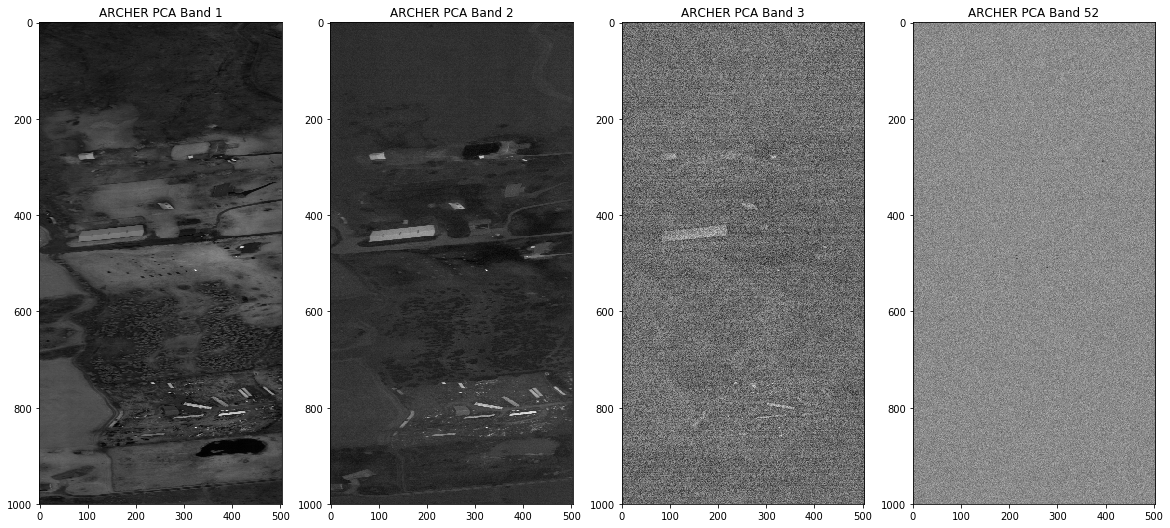

In [10]:
# Plot various bands from the image
# Squeeze() is needed to remove the single-dimensional band dimension
# before plotting (e.g. (nl, ns, 1) -> (nl, ns))
f, (plot1, plot2, plot3, plot4) = plt.subplots(1, 4)
plot1.imshow(reshape_pca_band(x_pca, 0), cmap=plt.gray());
plot1.set_title('ARCHER PCA Band 1');

plot2.imshow(reshape_pca_band(x_pca, 1), cmap=plt.gray());
plot2.set_title('ARCHER PCA Band 2');

plot3.imshow(reshape_pca_band(x_pca, 2), cmap=plt.gray());
plot3.set_title('ARCHER PCA Band 3');

plot4.imshow(reshape_pca_band(x_pca, 51), cmap=plt.gray());
plot4.set_title('ARCHER PCA Band 52');